# **Rice Disease Classification**



Rice is a staple crop in Egypt, but despite Egypt’s position as the top rice producer in Africa, it still relies on imports to meet the demands of its population. One of the main causes of this gap in Egypt is rice blast disease, which is responsible for 30% loss in rice production worldwide.

Early detection is the best way to manage crop diseases like rice blast, but rice blast is easily misclassified as brown spot disease - both are fungal diseases and have similar appearances in their early stage. With the current scarcity of experienced agricultural extension officers in the country, there is a clear case for recent technological advances in computer vision to help in early diagnosis, particularly by using multispectral images of crops.

 ##  **<span style='color:green'> Objective </span>**

The objective of this challenge is to predict the disease of a rice plant in RGB and Infrared images. Top solutions will receive money prizes and will be included in a joint publication with the organisers.

The covered classes are Brown Spot disease, Blast disease and healthy. [Zindi](https://zindi.africa/competitions/microsoft-rice-disease-classification-challenge) 

##  **<span style='color:green'> The solution </span> 🧠**
This solution is based on the architechture of the well known model <a href="https://pytorch.org/hub/pytorch_vision_densenet/">Densnet</a> and uses the technique of transfer learning to get some learned features form others tasks and use them in this contest to help our custom model to make accurate predictions.

<div align="center">
    <img src = "https://pytorch.org/assets/images/densenet1.png" 
        height = "90"
        width = "300">
</div>

The main framework used to implement the model is <a href="https://pytorch.org/get-started/locally/">Pytorch</a>.

# **SETUP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Imports**

In [ ]:
import os 
import sys 
import glob
import zipfile
import cv2 
from PIL import  Image

import math
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm 
import IPython.display as ipd
import matplotlib.pyplot as plt 


import warnings
warnings.simplefilter('ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **Environment configuration**

In [ ]:
PATHS = {
    'arch': '/content/drive/MyDrive/RiceDiseaseMODELS/Densenet161/',
    'raw': '/content/drive/MyDrive/RiceDiseaseChallenge/',
    'images': '/content/drive/MyDrive/RiceDiseaseChallenge/RGBImages/'
    }

os.makedirs(PATHS['arch'], exist_ok=True)

In [ ]:
seed = 2022 # for reproductibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# **Utilities**
  ### **Classes**
  * RiceDiseaseDataset : for creating dataset and perform data augmentation
  * RiceDiseasemodel : for creating model based on a pre-trained one


  ### **Functions**
  * training_fn : for creating dataset and perform data augmentation
  * evaluate : for evaluating model during training
  * predict : for making predictions using test images
  * run_fold : for training on a fold using model configuration (default model was resnet18)
  * load_models : for loading saved models related to folds

# **Classes**

In [ ]:
class RiceDiseaseDataset(torch.utils.data.Dataset):
    def __init__(self, df, task='train', size=(300, 230), use_tfms=True, **kwargs):
        super(RiceDiseaseDataset, self).__init__()
        self.df = df
        self.task = task
        self.size = size
        self.use_tfms = use_tfms
        self.c = 3

        self.train_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(),
        ])
        self.transforms = transforms.Compose([
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fn = self.df.loc[idx, 'file_name']

        img = cv2.imread(fn)
        img = cv2.resize(img, self.size)

        if self.use_tfms: spec = self.train_transforms(img)
        img = self.transforms(img)

        output = {
              'image': img,
          }

        if self.task == 'train':
            label = self.df.loc[idx, 'target']
            output.update({
              'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float )
          })

        return output   

In [ ]:
class RiceDiseaseModel(torch.nn.Module):
    def __init__(self, arch_name, pretrained=True, layer='fc', fc_size=512, out_size=3):
        super(RiceDiseaseModel, self).__init__()


        self.arch = getattr(models, arch_name)(pretrained)
        setattr(self.arch, layer, torch.nn.Linear(fc_size, out_size))

        torch.nn.init.xavier_normal_(getattr(getattr(self.arch, layer), 'weight'))

    def forward(self, x):
        x = self.arch(x)
        x = F.sigmoid(x)

        return x

# **Functions**

In [ ]:
def training_fn(dataloader, model, opt, criterion, epoch):
    avg_loss = 0
    avg_acc = 0
    model.to(device)

    model.train()

    for i, data in enumerate(dataloader):
        x,y = data['image'].to(device), data['label'].to(device)

        opt.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)

        avg_loss += loss
        avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()

        loss.backward()
        opt.step()

    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()
    print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader)))  




def predict(df, size, MODELS, bs=8):
    test_ds = RiceDiseaseDataset(df, task='test', size=size, use_tfms=False)
    testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

    predictions_labels = []
    predictions_proba = []

    out = None

    for data in tqdm(testloader):
        x = data['image'].to(device)

        for i in range(n_folds):
            if i == 0: out = MODELS[i](x)
            else: out += MODELS[i](x)

        out /= n_folds
        out_labels = out.argmax(1).cpu().detach().numpy()
        out_probas = out.cpu().detach().numpy()

        predictions_labels += out_labels.tolist()
        predictions_proba += out_probas.tolist()

    return predictions_labels ,predictions_proba 

In [ ]:
def evaluate(dataloader, model, criterion):
    avg_loss = 0
    avg_acc = 0
    avg_logloss = 0
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            x = data['image'].to(device)
            y = data['label'].to(device)

            pred = model(x)

            avg_loss += criterion(pred, y)
            avg_acc += ( y.argmax(1) == pred.argmax(1) ).float().mean()

        avg_loss /= len(dataloader)
        avg_acc /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f}'.format(avg_loss.cpu().detach().numpy(), 
                                                    avg_acc.cpu().detach().numpy()))

    return avg_loss

In [ ]:
def run_fold(fold, bs=16, 
             eval_bs=8, 
             lr=1e-4, 
             size=(300, 230), 
             arch='resnet34', 
             layer='fc', 
             fc_size=512,  
             path=PATHS['arch']):
    
    best_logloss = np.inf

    fold_train = train[train.fold != fold].reset_index(drop=True)
    fold_val = train[train.fold == fold].reset_index(drop=True)

    train_ds = RiceDiseaseDataset(fold_train, size=size)
    val_ds = RiceDiseaseDataset(fold_val, size=size, use_tfms=False)

    trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
    validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

    model = RiceDiseaseModel(arch, layer=layer, fc_size=fc_size)
    criterion = torch.nn.BCELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
  

    loader = tqdm(range(epochs), desc='Training')

    for epoch in loader:
        training_fn(trainloader, model, opt, criterion, epoch)
        avg_logloss = evaluate(validloader, model, criterion)

        if avg_logloss < best_logloss:
            best_logloss = avg_logloss
            torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

    return best_logloss
  

In [ ]:
def load_models(arch='resnet34', 
                layer='fc', 
                fc_size=512,  
                path=PATHS['arch']):
    
    MODELS = []
    
    for i in range(n_folds):
        MODELS.append(RiceDiseaseModel(arch_name=arch, layer=layer, fc_size=fc_size) )
        MODELS[i].to(device)
        MODELS[i].load_state_dict(torch.load(f'{path}model_state_dict_{i}.bin'))
        MODELS[i].eval()
        
    return MODELS

# **Dataset**

In [ ]:
Train = pd.read_csv(PATHS['raw'] + 'Train.csv')
submission = pd.read_csv(PATHS['raw'] + 'SampleSubmission.csv')

In [ ]:
train = Train[~Train.Image_id.str.contains('_rgn.jpg')].copy().reset_index(drop = True) 
sub = pd.DataFrame()
sub["image"] = submission["Image_id"].copy()

label_map = {"blast":0, "brown": 1, "healthy": 2}
train["Label"] = train["Label"].map(label_map).astype('str')

train.columns = ["image", "target"]

# Add file names
train['file_name'] = PATHS['images'] + train['image'] 
sub['file_name'] = PATHS['images'] + sub['image']

In [ ]:
train.head(2)

,image,target,file_name
0,id_004wknd7qd.jpg,0,/content/drive/MyDrive/RiceDiseaseChallenge/RG...
2,id_005sitfgr2.jpg,1,/content/drive/MyDrive/RiceDiseaseChallenge/RG...


In [ ]:
sub.head(2)

,image,file_name
0,id_00vl5wvxq3.jpg,/content/drive/MyDrive/RiceDiseaseChallenge/RG...
1,id_01hu05mtch.jpg,/content/drive/MyDrive/RiceDiseaseChallenge/RG...


# **Some data Visualization**

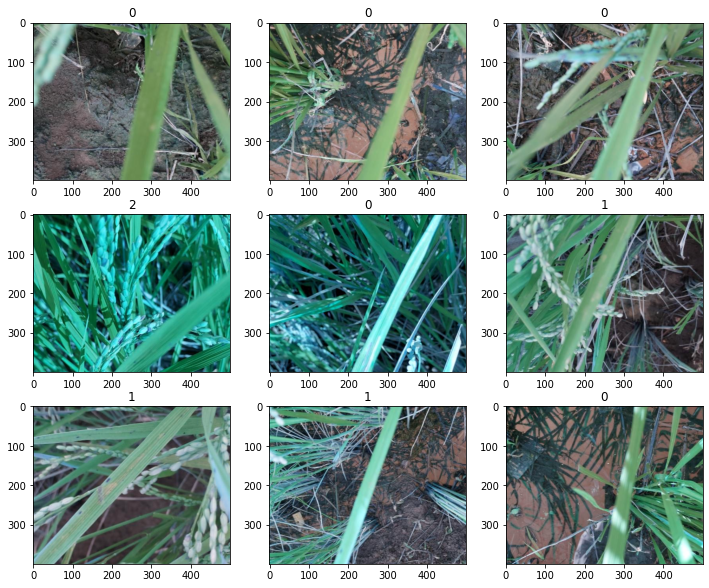

In [ ]:
#Training images
nrows = 3
train_images_list = train["image"].tolist()
rands = np.random.randint(len(train_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.file_name.iloc[rands[i]])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.target.iloc[rands[i]])
plt.show()

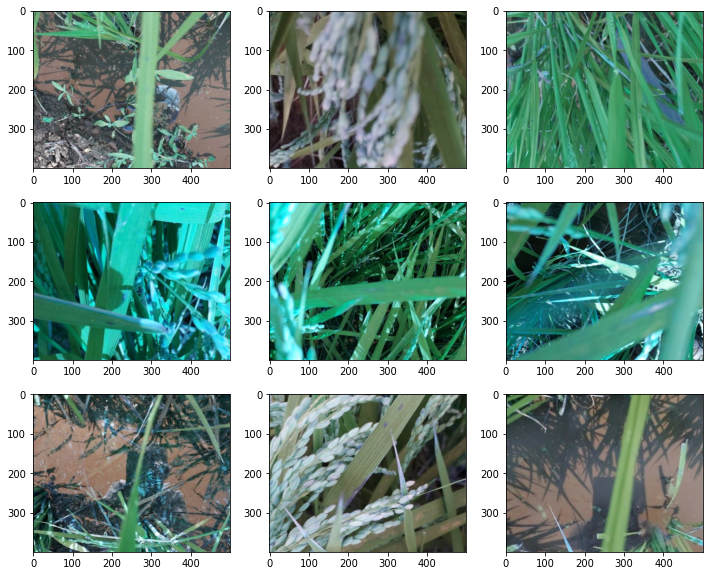

In [ ]:
#Test images
nrows = 3
test_images_list = sub["image"].tolist()
rands = np.random.randint(len(test_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = img = cv2.imread(sub.file_name.iloc[rands[i]])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
plt.show()

# **🏋️ Training the model 🏋️**

In [ ]:
n_folds = 10
train['fold'] = 0

fold = StratifiedKFold(n_splits = n_folds, random_state=seed, shuffle = True)

for i, (tr, vr) in enumerate(fold.split(train, train['target'])):
    train.loc[vr, 'fold'] = i

In [ ]:
epochs = 15          
device = 'cuda'         
size = (300, 300)        
arch = 'densenet161'
layer = 'classifier'
fc_size = 2208            
bs = 16           
eval_bs = 4             
lr = 1e-4       

In [ ]:
avg_logloss = 0   
best_fold = 0      
fold_logloss = np.inf

for fold in range(n_folds):
    _score = run_fold(fold, 
                      bs=bs, 
                      eval_bs=eval_bs, 
                      arch=arch, 
                      layer=layer, 
                      fc_size=fc_size, 
                      size=size, 
                      lr=lr)
    
    avg_logloss += _score

    if fold_logloss > _score:
        fold_logloss = _score
        best_fold = fold

print("\n [INFO] Avg LogLoss: ", avg_logloss/n_folds)

Training:   0%|          | 0/15 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.30299 - Acc : 0.81995
[Evaluation] Loss: 0.18637 - Acc : 0.88060
[Training] Epoch 1 : Loss: 0.10865 - Acc : 0.95075
[Evaluation] Loss: 0.18214 - Acc : 0.90672
[Training] Epoch 2 : Loss: 0.07158 - Acc : 0.96896
[Evaluation] Loss: 0.15197 - Acc : 0.94403
[Training] Epoch 3 : Loss: 0.04137 - Acc : 0.98538
[Evaluation] Loss: 0.11331 - Acc : 0.94776
[Training] Epoch 4 : Loss: 0.02473 - Acc : 0.99255
[Evaluation] Loss: 0.15968 - Acc : 0.94030
[Training] Epoch 5 : Loss: 0.02873 - Acc : 0.98620
[Evaluation] Loss: 0.13814 - Acc : 0.94030
[Training] Epoch 6 : Loss: 0.06598 - Acc : 0.97089
[Evaluation] Loss: 0.17283 - Acc : 0.92537
[Training] Epoch 7 : Loss: 0.04623 - Acc : 0.97751
[Evaluation] Loss: 0.16111 - Acc : 0.93284
[Training] Epoch 8 : Loss: 0.03431 - Acc : 0.98262
[Evaluation] Loss: 0.11934 - Acc : 0.95149
[Training] Epoch 9 : Loss: 0.02804 - Acc : 0.98813
[Evaluation] Loss: 0.09184 - Acc : 0.96642
[Training] Epoch 10 : Loss: 0.02471 - Acc : 0.99048
[Evaluat

Training:   0%|          | 0/15 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.30039 - Acc : 0.82988
[Evaluation] Loss: 0.16505 - Acc : 0.91791
[Training] Epoch 1 : Loss: 0.11159 - Acc : 0.94316
[Evaluation] Loss: 0.12286 - Acc : 0.93657
[Training] Epoch 2 : Loss: 0.06051 - Acc : 0.97392
[Evaluation] Loss: 0.09474 - Acc : 0.93657
[Training] Epoch 3 : Loss: 0.04664 - Acc : 0.97972
[Evaluation] Loss: 0.09983 - Acc : 0.94403
[Training] Epoch 4 : Loss: 0.03391 - Acc : 0.98675
[Evaluation] Loss: 0.13420 - Acc : 0.94030
[Training] Epoch 5 : Loss: 0.03613 - Acc : 0.98717
[Evaluation] Loss: 0.08529 - Acc : 0.95522
[Training] Epoch 6 : Loss: 0.02813 - Acc : 0.98827
[Evaluation] Loss: 0.11934 - Acc : 0.93159
[Training] Epoch 7 : Loss: 0.05077 - Acc : 0.97930
[Evaluation] Loss: 0.10212 - Acc : 0.95149
[Training] Epoch 8 : Loss: 0.01691 - Acc : 0.99545
[Evaluation] Loss: 0.09349 - Acc : 0.95149
[Training] Epoch 9 : Loss: 0.02830 - Acc : 0.98717
[Evaluation] Loss: 0.09188 - Acc : 0.95149
[Training] Epoch 10 : Loss: 0.02199 - Acc : 0.99255
[Evaluat

Training:   0%|          | 0/15 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.30168 - Acc : 0.80946
[Evaluation] Loss: 0.18447 - Acc : 0.90299
[Training] Epoch 1 : Loss: 0.10064 - Acc : 0.95143
[Evaluation] Loss: 0.10782 - Acc : 0.93284
[Training] Epoch 2 : Loss: 0.07010 - Acc : 0.96882
[Evaluation] Loss: 0.06946 - Acc : 0.95522
[Training] Epoch 3 : Loss: 0.05426 - Acc : 0.97792
[Evaluation] Loss: 0.12640 - Acc : 0.92164
[Training] Epoch 4 : Loss: 0.05524 - Acc : 0.97682
[Evaluation] Loss: 0.06256 - Acc : 0.97015
[Training] Epoch 5 : Loss: 0.04224 - Acc : 0.97958
[Evaluation] Loss: 0.10932 - Acc : 0.94030
[Training] Epoch 6 : Loss: 0.04574 - Acc : 0.97972
[Evaluation] Loss: 0.07097 - Acc : 0.97388
[Training] Epoch 7 : Loss: 0.01675 - Acc : 0.99462
[Evaluation] Loss: 0.05745 - Acc : 0.97015
[Training] Epoch 8 : Loss: 0.01315 - Acc : 0.99669
[Evaluation] Loss: 0.12954 - Acc : 0.95896
[Training] Epoch 9 : Loss: 0.01400 - Acc : 0.99669
[Evaluation] Loss: 0.07347 - Acc : 0.97761
[Training] Epoch 10 : Loss: 0.01694 - Acc : 0.99227
[Evaluat

Training:   0%|          | 0/15 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.29087 - Acc : 0.82326
[Evaluation] Loss: 0.19450 - Acc : 0.90299
[Training] Epoch 1 : Loss: 0.10498 - Acc : 0.94854
[Evaluation] Loss: 0.10891 - Acc : 0.94403
[Training] Epoch 2 : Loss: 0.06270 - Acc : 0.97185
[Evaluation] Loss: 0.21605 - Acc : 0.91418
[Training] Epoch 3 : Loss: 0.04788 - Acc : 0.97930
[Evaluation] Loss: 0.16553 - Acc : 0.92164
[Training] Epoch 4 : Loss: 0.03790 - Acc : 0.98593
[Evaluation] Loss: 0.10145 - Acc : 0.95522
[Training] Epoch 5 : Loss: 0.01653 - Acc : 0.99627
[Evaluation] Loss: 0.10859 - Acc : 0.95149
[Training] Epoch 6 : Loss: 0.05205 - Acc : 0.97682
[Evaluation] Loss: 0.17323 - Acc : 0.91791
[Training] Epoch 7 : Loss: 0.02735 - Acc : 0.98924
[Evaluation] Loss: 0.11254 - Acc : 0.97388
[Training] Epoch 8 : Loss: 0.01276 - Acc : 0.99448
[Evaluation] Loss: 0.13311 - Acc : 0.95149
[Training] Epoch 9 : Loss: 0.04640 - Acc : 0.97917
[Evaluation] Loss: 0.16770 - Acc : 0.91791
[Training] Epoch 10 : Loss: 0.04919 - Acc : 0.97448
[Evaluat

Training:   0%|          | 0/15 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.31226 - Acc : 0.81153
[Evaluation] Loss: 0.13119 - Acc : 0.92537
[Training] Epoch 1 : Loss: 0.11171 - Acc : 0.95075
[Evaluation] Loss: 0.13849 - Acc : 0.91045
[Training] Epoch 2 : Loss: 0.05227 - Acc : 0.97834
[Evaluation] Loss: 0.09506 - Acc : 0.97761
[Training] Epoch 3 : Loss: 0.05045 - Acc : 0.97889
[Evaluation] Loss: 0.11225 - Acc : 0.95522
[Training] Epoch 4 : Loss: 0.03356 - Acc : 0.98758
[Evaluation] Loss: 0.13199 - Acc : 0.94403
[Training] Epoch 5 : Loss: 0.04368 - Acc : 0.98096
[Evaluation] Loss: 0.12669 - Acc : 0.95522
[Training] Epoch 6 : Loss: 0.02397 - Acc : 0.98841
[Evaluation] Loss: 0.14081 - Acc : 0.94403
[Training] Epoch 7 : Loss: 0.02717 - Acc : 0.98965
[Evaluation] Loss: 0.08383 - Acc : 0.96269
[Training] Epoch 8 : Loss: 0.02611 - Acc : 0.99048
[Evaluation] Loss: 0.08220 - Acc : 0.97388
[Training] Epoch 9 : Loss: 0.02460 - Acc : 0.98758
[Evaluation] Loss: 0.10432 - Acc : 0.94776
[Training] Epoch 10 : Loss: 0.04217 - Acc : 0.97999
[Evaluat

Training:   0%|          | 0/15 [00:00<?, ?it/s]

# **Loading trained model for predictions**
   

In [ ]:
MODELS = load_models(arch=arch, layer=layer, fc_size=fc_size)

predictions_labels, predictions_proba = predict(sub, size=size, MODELS=MODELS, bs=2)

# **Making a submission**

In [ ]:
preds_test = predictions_proba

submission1 = submission.copy()
submission1[["blast", "brown", "healthy"]] = preds_test 
submission1.to_csv("Newsubmission2.csv", index=False)

### Author 

<table > 
    <thead>
        <tr> 
            <td>Name</td>
             <td>Zindi ID</td>
        </tr>
    </thead>
    <tbody> 
        <tr> 
            <td><span style='color:green'> Babawale Sodiq </span> </td>
             <td>@Babawale_Sodiq</td>
        </tr>
    </tbody>
</table>

